# Abstract

## Overview

In February of 2019, tens of thousands of domestic flights carried passengers around the country—every single day. Tens of thousands of aircraft being carefully tracked, monitored, organized and directed, and hundred of thousands or even millions of passengers count on those planes to get them where they're going. It's an incredible system, and most of the time it actually works. But when it doesn't, it hurts. Flight cancellations are extremely expensive, costing airlines a $1 billion per year. While flight cancellations due to weather may be inevitable, a significant portion of cancellations are due to circumstances under _our_ control. Modern air traffic control is a hundred years in the making and has certainly worked to minimize this issue already, but…can we do better?

## Question

Using data on American commercial flights, can we predict when a cancellation is likely to occur? As a bonus, can we predict _why_ the cancellation will occur?


*This is your space to describe your intentions for the project, before writing a single line of code. What are you studying? What are you hoping to build? If you can't explain that clearly before you start digging into the data, you're going to have a hard time planning where to go with this.*

# Obtain the Data

*Describe your data sources here and explain why they are relevant to the problem you are trying to solve.*

*Your code should download the data and save it in data/raw. If you've got the data from an offline source, describe where it came from and what the files look like. Don't do anything to the raw data files just yet; that comes in the next step.*

## Data Sources

My data set will be primarily based around the "[Marketing Carrier On-Time Performance](https://www.transtats.bts.gov/DatabaseInfo.asp?DB_ID=120&DB_URL=)" report released by the Bureau of Transportation Statistics. This database contains information on nearly every flight conducted by a significant U.S. carrier dating back to January 2018, which amounts to approximately 8 million observations. I expect I will supplement this dataset with additional features such as weather forecasts preceding a flight and additional statistics surrounding the model of plane for each flight.

*After completing this step, be sure to edit `references/data_dictionary` to include descriptions of where you obtained your data and what information it contains.*

In [ ]:
## %%writefile ../src/data/make_dataset.py

# Imports
from io import BytesIO
import os
import urllib.request
from zipfile import ZipFile


# Helper functions


def get_lookup_tables():
    # Reporting carrier lookup table
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_UNIQUE_CARRIERS'
    # Reporting airline lookup table
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_AIRLINE_ID'
    # Airport ID lookup table
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_AIRPORT_ID'
    # City Market ID lookup table
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_CITY_MARKET_ID'
    # Airport lookup table (SEA -> Seattle-Tacoma International)
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_AIRPORT'
    
    lookups = [
        'L_UNIQUE_CARRIERS',
        'L_AIRLINE_ID',
        'L_AIRPORT_ID',
        'L_CITY_MARKET_ID',
        'L_AIRPORT',
        'L_AIRPORT_ID',
        'L_CITY_MARKET_ID'
    ]
    lookup_base = 'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup='
    for table in lookups:
        download_lookup(lookup_base + table)
    pass


def get_weather_forecasts():
    # Weather forecast API
    'https://darksky.net/dev/docs#time-machine-request'
    key = 'c00a48b4e746f7a6b5a4caef59e18dc9'
    # Example
    request_format = f'''
    https://api.darksky.net/forecast/{key}/{latitude},{longitude},{time}
    '''
    example = '''
    https://api.darksky.net/forecast/0123456789abcdef9876543210fedcba/
    42.3601,-71.0589,255657600?exclude=currently,flags
    '''
    pass


def download_dataset(url, path, filename, overwrite='ask'):
    """
    Downloads zip file from specified url and extracts csv file to raw data 
    directory
    Input: 
        url: string of url from which to retrieve data
        path: string of directory path to store file in
        filename: string of desired filename
        overwrite: parameter for whether or not to overwrite existing files, if
            found. If 'y', any existing file with filename in path will be
            overwritten. If 'n', function will do nothing. If 'ask', function
            will prompt user to decide whether or not to replace file.
    Output: dataset stored in raw data directory
    """
    filepath = path + filename
    file_exists = os.path.isfile(filepath)
    if file_exists:
        if overwrite == 'ask':
            overwrite = input(f'{filename} already exists. Update? y/n: ')
        if overwrite.lower() != 'y':
            return
                              
    print(f'Beginning download of {filename}...')
    try:
        zip_f = urllib.request.urlopen(url)
        with ZipFile(BytesIO(zip_f.read())) as my_zip_file:
            for f in my_zip_file.namelist():
                if '.csv' in f:
                    with open(filepath, 'wb') as output:
                        for line in my_zip_file.open(f).readlines():
                            output.write(line)
        print(f'Successfully wrote {filename} to {path}')
                              
    except urllib.request.HTTPError:
        print(f'Failed to download {filename}')
        return


def get_flight_data_url(year, month):
    '''
    Generate URL to download pre-zipped csv of flight data for a given month as
    provided by the Bureau of Transportation Statistics
    Input: Year in format YYYY (int), Month in format of (M)M, i.e. 3, or 11
    Output: download URL as a string
    '''
    base_url = 'http://transtats.bts.gov/PREZIP/'
    tail = 'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_'
    slug = f'{year}_{month}.zip'
    return base_url + tail + slug
    

def get_flight_data(start, end, path):
    '''
    Downloads a variety of flight data tables from:
    https://www.transtats.bts.gov/Fields.asp
    '''
    # Download all BTS datasets
    for year in range(start, end):
        for month in range(1,13):
            filename = f'flight_data_{year}-{month}.csv'
            url = get_flight_data_url(year, month)
            download_dataset(url, path, filename)
    pass


def run():
    """
    Executes a set of helper functions that download data from one or more sources
    and saves those datasets to the data/raw directory.
    """
    path = '../data/raw/'
    get_flight_data(2003, 2020, path)
    # download_dataset_1(url)
    # download_dataset_2(url)
    # save_dataset_1('data/raw', filename)
    # save_dataset_2('data/raw', filename)
    pass

In [ ]:
run()

In [ ]:
df = pd.read_csv('../data/raw/On_Time_Marketing_Carrier_On_Time_Performance_(Beginning_January_2018)_2019_2.csv')

In [ ]:
df.shape

In [ ]:
print(list(df.columns))

In [ ]:
df['CancellationCode'].value_counts()

In [ ]:
df.head()

In [ ]:
pd.Series(df['DayofMonth'].value_counts()).mean()

In [ ]:
df.groupby('DayofMonth')['Cancelled'].value_counts()

# Scrub the Data

*Look through the raw data files and see what you will need to do to them in order to have a workable data set. If your source data is already well-formatted, you may want to ask yourself why it hasn't already been analyzed and what other people may have overlooked when they were working on it. Are there other data sources that might give you more insights on some of the data you have here?*

*The end goal of this step is to produce a [design matrix](https://en.wikipedia.org/wiki/Design_matrix), containing one column for every variable that you are modeling, including a column for the outputs, and one row for every observation in your data set. It needs to be in a format that won't cause any problems as you visualize and model your data.*

## Features
The following is a list of features I'd like to have in the design matrix:


| Feature                               | Description                                                  | Type        | Purpose |
| ------------------------------------- | ------------------------------------------------------------ | ----------- | ------- |
| Airline ID                            | ID number to identify unique airline                         | Categorical | Key     |
| AL_C_rate_day                         | Flight cancellation rate by this airline at this airport over past 24 hours | Continuous  | Feature |
| AL_C_rate_7                           | Flight cancellation rate by this airline on this weekday 1 week ago | Continuous  | Feature |
| AL_C_avg_rate_week                    | Flight cancellation rate by this airline at this airport over past 7 days | Continuous  | Feature |
| AL_C_rate_28                          | Flight cancellation rate by this airline on this weekday 4 weeks ago | Continuous  | Feature |
| AL_C_avg_rate_month                   | Flight cancellation rate by this airline at this airport over past 30 days | Continuous  | Feature |
| AL_C_rate_364                         | Flight cancellation rate by this airline on this weekday 52 weeks ago | Continuous  | Feature |
| AL_C_avg_rate_year                    | Flight cancellation rate by this airline at this airport over past 365 days | Continuous  | Feature |
| Tail number                           | Unique airplane identifier ID                                | Categorical | Key     |
| AP_C_rate_day                         | Flight cancellation rate by this airplane over past 24 hours | Continuous  | Feature |
| AP_C_rate_7                           | Flight cancellation rate by this airplane on this weekday 1 week ago | Continuous  | Feature |
| AP_C_avg_rate_week                    | Flight cancellation rate by this airplane at this airport over past 7 days | Continuous  | Feature |
| AP_C_rate_28                          | Flight cancellation rate by this airplane on this weekday 4 weeks ago | Continuous  | Feature |
| AP_C_avg_rate_month                   | Flight cancellation rate by this airplane at this airport over past 30 days | Continuous  | Feature |
| AP_C_rate_364                         | Flight cancellation rate by this airplane on this weekday 52 weeks ago | Continuous  | Feature |
| AP_C_avg_rate_year                    | Flight cancellation rate by this airplane at this airport over past 365 days | Continuous  | Feature |
| Origin Airport ID                     | Unique airport identifier ID for flight origin               | Categorical | Key     |
| orig_C_rate_day                       | Flight cancellation rate for flights departing from origin airport over past 24 hours | Continuous  | Feature |
| repeat same pattern as above          |                                                              |             |         |
| Origin City Market                    | ID for area that may be served by several airlines           | Categorical | Key     |
| OCM_C_rate_day                        | Flight cancellation rate for flights departing from origin city market over past 24 hours | Continuous  | Feature |
| repeat same pattern as above          |                                                              |             |         |
| Dest Airport ID                       | Unique airport identifier ID for destination                 | Categorical | Key     |
| dest_C_rate_day                       | Flight cancellation rate for flights heading to destination airport over past 24 hours | Continuous  | Feature |
| repeat same pattern as above          |                                                              |             |         |
| Dest City Market                      | ID for area that may be served by several airlines           | Categorical | Key     |
| DCM_C_rate_day                        | Flight cancellation rate for flights heading to destination city market over past 24 hours | Continuous  | Feature |
| repeat same pattern as above          |                                                              |             |         |
| Departure time                        | Scheduled departure time                                     | ?           |         |
| Airtime                               | Planned time in air, in minutes                              | Continuous  |         |
| Distance                              | Planned route distance                                       | Continuous  |         |
| On-time incoming arrival percentage   | Percent of flights that arrive at departure airport on-time  | Continuous  |         |
| On-time outgoing departure percentage | Percent of flights that depart from departure airport on-time | Continuous  |         |
| Historical cancellation percentages   | All time average                                             | Continuous  |         |
|                                       | 1 day ago                                                    | Continuous  |         |
|                                       | 7 days ago                                                   | Continuous  |         |
|                                       | 30 days ago                                                  | Continuous  |         |
|                                       | 364 days ago                                                 | Continuous  |         |
|                                       | For this airline                                             | Continuous  |         |
|                                       | From this airport                                            | Continuous  |         |
|                                       | To that airport                                              | Continuous  |         |
|                                       | On this airplane (tail number)                               | Continuous  |         |
|                                       | On this airplane model                                       | Continuous  |         |
| Historical delays (goes back to 2003) | The average number of minutes that a similar incoming flight has been delayed (in minutes) over the avove time periods, for the reasons: carrier delay, weather delay, national air system delay, security delay, and late aircraft delay |             |         |
|                                       |                                                              |             |         |
| Weather Forecast                      | What the weather forecast was ~24 hours ago, in degrees      | Continuous  |         |
| Other airline/craft statistics        |                                                              |             |         |
| Cancelled                             | Boolean for whether or not flight is cancelled, 1=Yes        | Boolean     |         |
| Cancellation Code                     | Reason for cancellation (carrier, weather, national air system, security) | Categorical |         |



In [509]:
# %%writefile ../src/features/build_features.py

# Imports
import csv
from os import listdir
import subprocess
import sys
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
import sqlalchemy
from sqlalchemy import create_engine
import numpy as np
import pandas as pd


# Helper functions
def export_design_matrix(df):
    """
    Pickles design matrix and stores in processed directory to be trained on
    Input: clean design matrix df containing only features and target
    Outpu: pickled design matrix in data directory
    """
    df = df.drop('date', axis=1)
    display(df.sample(10))
    df.to_pickle('../data/processed/data.pkl')
    pass


def get_past_c_rates():
    """
    Returns average cancellation rate of n days ago
    """
    q = f"""
    SELECT 
        CAST(flightdate AS DATE) AS date,
        LAG(AVG(cancelled), 1) OVER(ORDER BY flightdate) AS CR_1_day_ago,
        LAG(AVG(cancelled), 7) OVER(ORDER BY flightdate) AS CR_7_day_ago,
        LAG(AVG(cancelled), 28) OVER(ORDER BY flightdate) AS CR_28_day_ago,
        LAG(AVG(cancelled), 364) OVER(ORDER BY flightdate) AS CR_364_day_ago
    FROM flights
    WHERE 
        origin = 'SEA'
    GROUP BY flightdate
    ORDER BY flightdate
    ;"""
    return pd.read_sql(q, engine)#, index_col='date')


def build_features():
    """
    """
    # Design matrix
    dm = """
    SELECT
        CAST(flightdate AS DATE) || '_fl' || flight_number_reporting_airline
            AS flight,
        CAST(flightdate AS DATE) AS date,
        crselapsedtime,
        distance,
        cancelled
    FROM flights
    WHERE flightdate > '2017-01-01' AND
        origin = 'SEA'
    ORDER BY date
    ;"""
    df = pd.read_sql(dm, engine, index_col='flight')
    
    past_c_rates = get_past_c_rates()
    df = df.merge(past_c_rates, how='left', on='date')
    df = df.dropna()
    return df

# Airline cancellation rate
def get_avg_cancellation_rate(by, time):
    pass


def get_past_cancellation_rate(by, time):
    pass


def run_query(query, params, engine):
    '''
    Opens a connection to database to run a query, q
    Input: 
        query (str), a SQL command that requests output
        params (dict), parameters for connecting to psql, including user, host,
            and port
    Output: a pandas dataframe containing the query output
    '''
    return pd.read_sql(query, engine)

    
def show_tables(params):
    # Returns a list of all tables and views in our database
    q = """
    SELECT tablename 
    FROM pg_catalog.pg_tables 
    WHERE schemaname != 'pg_catalog' AND schemaname != 'information_schema';
    """
    return run_query(q, params)


def run_command(command, params):
    '''
    Opens a connection to database to run a command with no output
    Input: 
        command (str), a SQL query that commits an action
        params (dict), parameters for connecting to psql, including user, host,
            and port
    '''
    with connect(**params) as conn:
        conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
        cur = conn.cursor()
        cur.execute(command)
        pass
    
    
def check_table_exists(table, cursor):
    '''
    Executes a query and checks if item is in returned results
    Input: 
        query (str), a SQL query returning list of items to look within
        item (str), the name of the item to check if exists
        cursor, a psycogp2 cursor object
    Output: boolean, True if item exists
    '''
    query = """
    SELECT tablename 
    FROM pg_catalog.pg_tables 
    WHERE schemaname != 'pg_catalog' AND schemaname != 'information_schema';
    """
    cursor.execute(query)
    items = [i[0] for i in cursor.fetchall()]
    print(f'Found tables: {items}')
    exists = table in items
    return exists


def make_table(path, file, engine, table):
    df = pd.read_csv(path + file)

    drop_cols = [
        'DOT_ID_Reporting_Airline',
        'IATA_CODE_Reporting_Airline', 
        'OriginAirportSeqID', 
        'OriginStateFips',
        'OriginWac',
        'DestAirportSeqID', 
        'DestStateFips',
        'DestWac',
        'TaxiOut',
        'WheelsOff', 
        'WheelsOn', 
        'TaxiIn'
    ]

    short_df = df[df.columns[:61]].drop(drop_cols, axis=1)

    shorter_df = short_df[
        short_df['Origin'].str.contains('SEA') |
        short_df['Dest'].str.contains('SEA')
    ]

    index = (shorter_df['FlightDate'].astype(str) 
             + '_' + shorter_df['Flight_Number_Reporting_Airline'].astype(str))

    shorter_df.set_index(
        keys=index,
        inplace=True
    )

    shorter_df.columns = [col.lower() for col in shorter_df.columns]
    
    # Define types
    types = {
        'year': sqlalchemy.types.INTEGER(),
        'quarter': sqlalchemy.types.INTEGER(),
        'month': sqlalchemy.types.INTEGER(),
        'dayofmonth': sqlalchemy.types.INTEGER(),
        'dayofweek': sqlalchemy.types.INTEGER(),
        'flightdate': sqlalchemy.DateTime(),
        'reporting_airline': sqlalchemy.types.VARCHAR(),
        'tail_number': sqlalchemy.types.VARCHAR(),
        'flight_number_reporting_airline': sqlalchemy.types.VARCHAR(),
        'originairportid': sqlalchemy.types.VARCHAR(),
        'origincitymarketid': sqlalchemy.types.VARCHAR(),
        'origin': sqlalchemy.types.VARCHAR(),
        'origincityname': sqlalchemy.types.VARCHAR(),
        'originstate': sqlalchemy.types.VARCHAR(),
        'originstatename': sqlalchemy.types.VARCHAR(),
        'destairportid': sqlalchemy.types.VARCHAR(),
        'destcitymarketid': sqlalchemy.types.VARCHAR(),
        'dest': sqlalchemy.types.VARCHAR(),
        'destcityname': sqlalchemy.types.VARCHAR(),
        'deststate': sqlalchemy.types.VARCHAR(),
        'deststatename': sqlalchemy.types.VARCHAR(),
        'crsdeptime': sqlalchemy.types.INTEGER(),
        'deptime': sqlalchemy.types.INTEGER(),
        'depdelay': sqlalchemy.types.INTEGER(),
        'depdelayminutes': sqlalchemy.types.INTEGER(),
        'depdel15': sqlalchemy.types.BOOLEAN(),
        'departuredelaygroups': sqlalchemy.types.INTEGER(),
        'deptimeblk': sqlalchemy.types.VARCHAR(),
        'crsarrtime': sqlalchemy.types.INTEGER(),
        'arrtime': sqlalchemy.types.INTEGER(),
        'arrdelay': sqlalchemy.types.INTEGER(),
        'arrdelayminutes': sqlalchemy.types.INTEGER(),
        'arrdel15': sqlalchemy.types.BOOLEAN(),
        'arrivaldelaygroups': sqlalchemy.types.INTEGER(),
        'arrtimeblk': sqlalchemy.types.VARCHAR(),
        'cancelled': sqlalchemy.types.INTEGER(),
        'cancellationcode': sqlalchemy.types.VARCHAR(),
        'diverted': sqlalchemy.types.VARCHAR(),
        'crselapsedtime': sqlalchemy.types.VARCHAR(),
        'actualelapsedtime': sqlalchemy.types.INTEGER(),
        'airtime': sqlalchemy.types.INTEGER(),
        'flights': sqlalchemy.types.INTEGER(),
        'distance': sqlalchemy.types.INTEGER(),
        'distancegroup': sqlalchemy.types.INTEGER(),
        'carrierdelay': sqlalchemy.types.VARCHAR(),
        'weatherdelay': sqlalchemy.types.VARCHAR(),
        'nasdelay': sqlalchemy.types.VARCHAR(),
        'securitydelay': sqlalchemy.types.VARCHAR(),
        'lateaircraftdelay': sqlalchemy.types.VARCHAR(),
    }
                  
    # Add to SQL table
    shorter_df.to_sql(
        table, engine, if_exists='append', dtype=types, index=False)
    print(f'Added {file} to table {table}')
                  
    int_path = '../data/interim/'
    shorter_df.to_csv(f'{int_path}reduced_{file}')
    print(f'Wrote {file} to {int_path}')
    pass

                  
def check_db_exists(db, cursor):
    '''
    Executes a query and checks if item is in returned results
    Input: 
        query (str), a SQL query returning list of items to look within
        item (str), the name of the item to check if exists
        cursor, a psycogp2 cursor object
    Output: boolean, True if item exists
    '''
    query = 'SELECT datname FROM pg_database;'
    cursor.execute(query)
    items = [i[0] for i in cursor.fetchall()]
    print(f'Found items: {items}')
    exists = db in items
    return exists
                  
                  
def create_db(dbname, params):
    '''
    Connects to psql as default user and creates new database if it doesn't
    already exist
    Input:
        dbname (string), name of new database
        params (dict), parameters for connecting to psql, including user, host,
        and port
    Output: database created in psql
    '''
    
    temp_params = params.copy()
    temp_params['dbname'] = 'postgres'
    with connect(**temp_params) as conn:
        conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
        cur = conn.cursor()
        exists = check_db_exists(dbname, cur)
        if not exists:
            cur.execute(f'CREATE DATABASE {dbname}')
            print(f'Created database {dbname}')
    pass
        

def build_raw_database():
    '''
    Constructs database from raw data CSVs previously downloaded
    '''
    path = '../data/raw/'
    params = {
        'user': 'scottbutters',
        'host': '127.0.0.1',
        'port': 5432,
        'dbname': 'raw_flight_data'
    }
    table_name = 'flights'
    
    connection_string = f"postgresql:///{params['dbname']}"
    engine = create_engine(connection_string)

    # Create db if DNE yet
    create_db(dbname=params['dbname'], params=params)
    
    # Check whether table exists and prompt about dropping
    with connect(**params) as conn:
        conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
        print(f"Connecting to database {params['dbname']}")
        cur = conn.cursor()
        exists = check_table_exists(table_name, cur)
        if exists:
            overwrite = input(f'{table_name} already exists. Update? y/n: ')
            if overwrite.lower() != 'y':
                return
            run_command('DROP TABLE flights;', params)

    # Collect list of csvs
    files = [f for f in listdir(path) if '.csv' in f]
    files = sorted(files)
    
    # Shrink files and load all into SQL table
    for file in files:
        make_table(path, file, engine, table_name)
    pass
        
        
def run():
    """
    Executes a set of helper functions that read files from data/raw, cleans them,
    and converts the data into a design matrix that is ready for modeling.
    """
    build_raw_database()
#     data = clean_data()
#     create_
    
    # clean_dataset_1('data/raw', filename)
    # clean_dataset_2('data/raw', filename)
    # save_cleaned_data_1('data/interim', filename)
    # save_cleaned_data_2('data/interim', filename)
    data = build_features()
    export_design_matrix(data)
    return data

In [510]:
data = run()

Found items: ['postgres', 'scottbutters', 'template1', 'template0', 'names', 'store', 'raw_flight_data', 'test']
Connecting to database raw_flight_data
Found tables: ['flights_2003_1', 'flights_2003_10', 'flights_2003_11', 'flights']
flights already exists. Update? y/n: n


,crselapsedtime,distance,cancelled,cr_1_day_ago,cr_7_day_ago,cr_28_day_ago,cr_364_day_ago
101885,150.0,1024,0,0.002564,0.002463,0.020642,0.002747
140925,240.0,1733,0,0.011268,0.005362,0.002618,0.002924
89021,328.0,2422,0,0.002268,0.002398,0.000000,0.000000
206340,232.0,1709,0,0.000000,0.000000,0.000000,0.004587
128870,315.0,2415,0,0.013937,0.000000,0.000000,0.009464
247503,210.0,1399,0,0.007937,0.005102,0.012469,0.005195
259456,395.0,2688,0,0.000000,0.000000,0.000000,0.005249
36944,154.0,909,0,0.000000,0.000000,0.005525,0.000000
60979,214.0,1448,0,0.004587,0.000000,0.010076,0.002294
175828,164.0,1050,0,0.000000,0.009288,0.000000,0.003215


In [494]:
data.shape

(296485, 4)

In [263]:
q = """
SELECT 
    flightdate, 
    SUM(cancelled) AS cancellations,
    COUNT(cancelled) AS flights,
    SUM(cancelled)/CAST(COUNT(cancelled) AS FLOAT) AS canc_rate,
    AVG(cancelled) AS avg_canc_rate
FROM flights
WHERE 
    origin = 'SEA' AND
    flightdate > '2003-01-03'
GROUP BY flightdate
ORDER BY flightdate
LIMIT 5
;
"""

pd.read_sql(q, engine)

,flightdate,cancellations,flights,canc_rate,avg_canc_rate
0,2003-01-04,0,250,0.000000,0.000000
1,2003-01-05,0,264,0.000000,0.000000
2,2003-01-06,4,283,0.014134,0.014134
3,2003-01-07,4,275,0.014545,0.014545
4,2003-01-08,12,273,0.043956,0.043956


In [504]:
def get_past_c_rates():
    """
    Returns average cancellation rate of n days ago
    """
    q = f"""
    SELECT 
        CAST(flightdate AS DATE) AS date,
        LAG(AVG(cancelled), 1) OVER(ORDER BY flightdate) AS CR_1_day_ago,
        LAG(AVG(cancelled), 7) OVER(ORDER BY flightdate) AS CR_7_day_ago,
        LAG(AVG(cancelled), 28) OVER(ORDER BY flightdate) AS CR_28_day_ago,
        LAG(AVG(cancelled), 364) OVER(ORDER BY flightdate) AS CR_364_day_ago
    FROM flights
    WHERE 
        origin = 'SEA'
    GROUP BY flightdate
    ORDER BY flightdate
    LIMIT 500;
    """
    return pd.read_sql(q, engine, index_col='date')

lags = prev_average()
lags.tail()

,cr_1_day_ago,cr_7_day_ago,cr_28_day_ago,cr_364_day_ago
date,,,,
2004-05-10,0.013514,0.006536,0.006803,0.024476
2004-05-11,0.016234,0.016287,0.006849,0.010601
2004-05-12,0.019608,0.006494,0.000000,0.000000
2004-05-13,0.006494,0.009709,0.000000,0.003497
2004-05-14,0.006472,0.009677,0.003390,0.010490


In [316]:
q = """
SELECT 
    flightdate,
    make_date(year, month, dayofmonth)
FROM flights LIMIT 5;
"""
pd.read_sql(q, engine)

,flightdate,make_date
0,2003-01-01,2003-01-01
1,2003-01-02,2003-01-02
2,2003-01-03,2003-01-03
3,2003-01-04,2003-01-04
4,2003-01-05,2003-01-05


In [317]:
q = """
SELECT * FROM flights LIMIT 5"""
pd.read_sql(q, engine)

,year,quarter,month,dayofmonth,dayofweek,flightdate,reporting_airline,tail_number,flight_number_reporting_airline,originairportid,...,actualelapsedtime,airtime,flights,distance,distancegroup,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay
0,2003,1,1,1,3,2003-01-01,NW,N530US,155,13487,...,224,200,1,1399,6,None,None,None,None,None
1,2003,1,1,2,4,2003-01-02,NW,N533US,155,13487,...,239,205,1,1399,6,None,None,None,None,None
2,2003,1,1,3,5,2003-01-03,NW,N503US,155,13487,...,242,220,1,1399,6,None,None,None,None,None
3,2003,1,1,4,6,2003-01-04,NW,N529US,155,13487,...,226,198,1,1399,6,None,None,None,None,None
4,2003,1,1,5,7,2003-01-05,NW,N545US,155,13487,...,227,182,1,1399,6,None,None,None,None,None


In [346]:
# Design matrix
dm = """
SELECT
    CAST(flightdate AS DATE) || '_fl' || flight_number_reporting_airline
        AS flight,
    flightdate,
    dayofweek,
    airtime,
    distance,
    LAG(AVG(cancelled), 1) OVER(
        ORDER BY flightdate) AS avg_cancellations_1,
    cancelled
FROM flights
GROUP BY flightdate
LIMIT 5;
"""
pd.read_sql(dm, engine)

ProgrammingError: (psycopg2.errors.GroupingError) column "flights.flight_number_reporting_airline" must appear in the GROUP BY clause or be used in an aggregate function
LINE 3:     CAST(flightdate AS DATE) || '_fl' || flight_number_repor...
                                                 ^

[SQL: 
SELECT
    CAST(flightdate AS DATE) || '_fl' || flight_number_reporting_airline
        AS flight,
    flightdate,
    dayofweek,
    airtime,
    distance,
    LAG(AVG(cancelled), 1) OVER(
        ORDER BY flightdate) AS avg_cancellations_1,
    cancelled
FROM flights
GROUP BY flightdate
LIMIT 5;
]
(Background on this error at: http://sqlalche.me/e/f405)

In [348]:
# Design matrix
dm = """
SELECT
    CAST(flightdate AS DATE) || '_fl' || flight_number_reporting_airline
        AS flight,
    dayofweek,
    airtime,
    distance,
    cancelled
FROM flights
LIMIT 5;
"""
pd.read_sql(dm, engine, index_col='flight')

,dayofweek,airtime,distance,cancelled
flight,,,,
2003-01-01_fl155,3,200,1399,0
2003-01-02_fl155,4,205,1399,0
2003-01-03_fl155,5,220,1399,0
2003-01-04_fl155,6,198,1399,0
2003-01-05_fl155,7,182,1399,0


In [303]:
q = """
WITH daily AS (
    SELECT 
        flightdate, 
        SUM(cancelled) AS cancellations,
        COUNT(cancelled) AS flights
    FROM flights
    WHERE origin = 'SEA'
    GROUP BY flightdate
    ORDER BY flightdate
)

SELECT 
    SUM(cancellations) / SUM(CAST(flights AS FLOAT))
        OVER(
            ORDER BY flightdate
            RANGE BETWEEN '30 day' PRECEDING AND '1 day' PRECEDING)
        AS canc_rate
FROM daily d
WHERE 
    flightdate > '2003-01-29'
GROUP BY flightdate
ORDER BY flightdate
LIMIT 15
;
"""

pd.read_sql(q, engine)

ProgrammingError: (psycopg2.errors.GroupingError) column "d.flights" must appear in the GROUP BY clause or be used in an aggregate function
LINE 14:     SUM(cancellations) / SUM(CAST(flights AS FLOAT))
                                           ^

[SQL: 
WITH daily AS (
    SELECT 
        flightdate, 
        SUM(cancelled) AS cancellations,
        COUNT(cancelled) AS flights
    FROM flights
    WHERE origin = 'SEA'
    GROUP BY flightdate
    ORDER BY flightdate
)

SELECT 
    SUM(cancellations) / SUM(CAST(flights AS FLOAT))
        OVER(
            ORDER BY flightdate
            RANGE BETWEEN '30 day' PRECEDING AND '1 day' PRECEDING)
        AS canc_rate
FROM daily d
WHERE 
    flightdate > '2003-01-29'
GROUP BY flightdate
ORDER BY flightdate
LIMIT 15
;
]
(Background on this error at: http://sqlalche.me/e/f405)

In [341]:
q = """
SELECT 
    flightdate, 
    AVG(cancelled)
        OVER(
            PARTITION BY flightdate
            ORDER BY flightdate 
            RANGE BETWEEN '30 days' PRECEDING AND '1 days' PRECEDING
                )  AS avg_cancellations
FROM flights
WHERE origin = 'SEA' AND
    flightdate > '2003-02-02'
ORDER BY flightdate
LIMIT 10
;
"""

pd.read_sql(q, engine)

,flightdate,avg_cancellations
0,2003-02-03,None
1,2003-02-03,None
2,2003-02-03,None
3,2003-02-03,None
4,2003-02-03,None
5,2003-02-03,None
6,2003-02-03,None
7,2003-02-03,None
8,2003-02-03,None
9,2003-02-03,None


*Before moving on to exploratory analysis, write down some notes about challenges encountered while working with this data that might be helpful for anyone else (including yourself) who may work through this later on.*

# Explore the Data

*Before you start exploring the data, write out your thought process about what you're looking for and what you expect to find. Take a minute to confirm that your plan actually makes sense.*

*Calculate summary statistics and plot some charts to give you an idea what types of useful relationships might be in your dataset. Use these insights to go back and download additional data or engineer new features if necessary. Not now though... remember we're still just trying to finish the MVP!*

In [485]:
## %%writefile ../src/visualization/visualize.py

# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# helper functions go here
def plot_features(df, sample_size=5000):
    
    sample = (df.sample(5000, random_state=44)) 
    sns.pairplot(sample,hue='cancelled', plot_kws=dict(alpha=.3, edgecolor='none'))


def run():
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    # data = load_features('data/processed')
    # describe_features(data, 'reports/')
    # generate_charts(data, 'reports/figures/')
    pass


/anaconda3/envs/project3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/envs/project3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


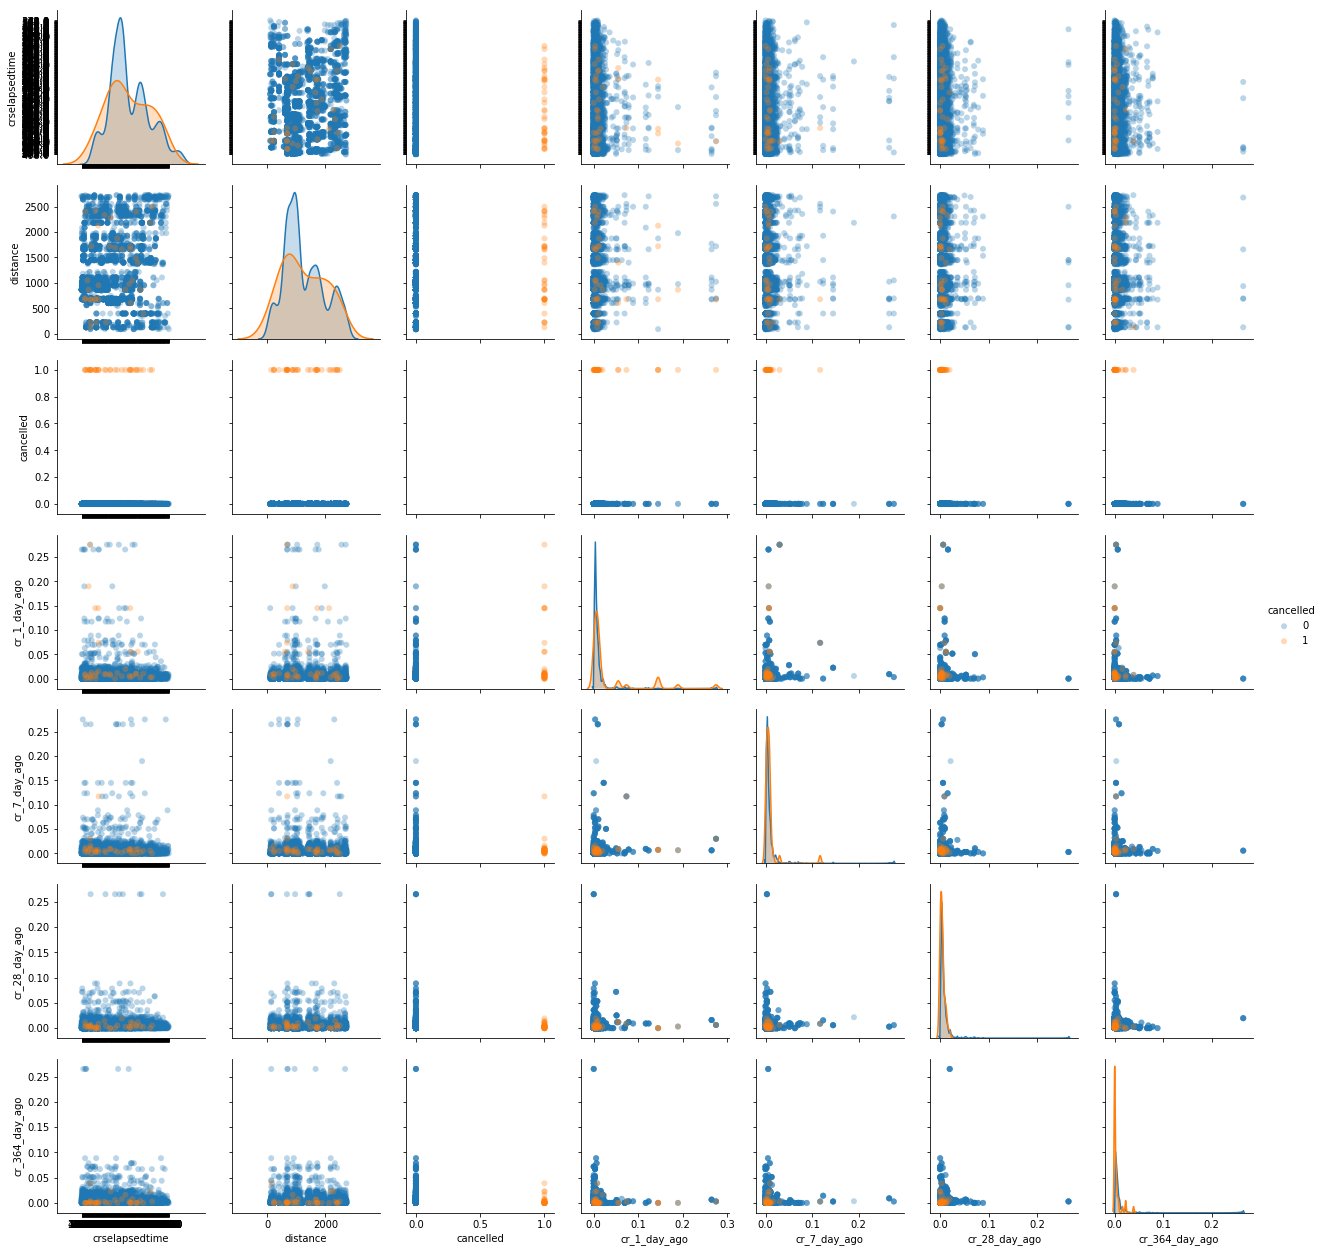

In [515]:
plot_features(data)

*What did you learn? What relationships do you think will be most helpful as you build your model?*

# Model the Data

*Describe the algorithm or algorithms that you plan to use to train with your data. How do these algorithms work? Why are they good choices for this data and problem space?*

In [511]:
## %%writefile ../src/models/train_model.py

# Imports
import pickle

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, TimeSeriesSplit, cross_validate
from sklearn import ensemble, metrics, neighbors, neural_network, svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


# Helper functions
def save_to(filepath, item):
    """
    Pickles item sand saves it to path
    Input: object to be pickled, string containing directory and filename
    Output: pickled object stored to provided path
    """
    with open(filepath, 'wb') as to_write:
        pickle.dump(item, to_write)
    return


def build_model(model):
    """
    Instantiates model
    Input: model (str), name of model to instantiate
    Output: instantiated model
    Model options are:
        'Logistic Regression',
        'Naive Bayes',
        'Linear SVM',
        'Linear MLP',
        'KNN',
        'Random Forest',
        'Radial SVM',
        'Relu MLP'
    """
    models = {
        'Logistic Regression': LogisticRegression(solver='lbfgs'),
        'Naive Bayes':GaussianNB(),
        'Linear SVM': svm.LinearSVC(),
        'Linear MLP': neural_network.MLPClassifier(activation="identity"),
        'KNN': neighbors.KNeighborsClassifier(),
        'Random Forest': ensemble.RandomForestClassifier(n_estimators=100),
        'Radial SVM': svm.SVC(gamma="scale"),
        'Relu MLP': neural_network.MLPClassifier()
    }
    return models[model]


def save_train_test(cv_train, cv_test, train, test, path):
    """
    Saves train and test data to pickles
    Input: train and test data and path to store pickles in
    Output: pickled files in directory
    """
    save_to(path + 'cv_train.pkl', cv_train)
    save_to(path + 'cv_test.pkl', cv_test)
    save_to(path + 'train.pkl', train)
    save_to(path + 'test.pkl', test)
    pass


def train_test_split(df):
    """
    """
#     tscv = TimeSeriesSplit(n_splits=2)
#     train_index, test_index = tscv.split(df)
    n = df.shape[0]
    cv_train, cv_test = df.iloc[:n//3], df.iloc[n//3 : 2*n//3]
    train, test = df.iloc[:2*n//3], df.iloc[2*n//3:]
    
    return cv_train, cv_test, train, test
    
    
def load_features(filepath):
    """
    Loads data from csv and returns as dataframe
    Input: relative filepath pointing to file
    Output: dataframe containing data from csv
    """
    data = pd.read_pickle(filepath)
    return data


def run(method='Logistic Regression'):
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    data = load_features('../data/processed/data.pkl')
    cv_train, cv_test, train, test = train_test_split(data)
    save_train_test(cv_train, cv_test, train, test, '../data/processed/')
    model = build_model(method)
    target = 'cancelled'
    X_train, y_train = cv_train.drop(target, axis=1), cv_train[target]
    model.fit(X_train, y_train)
    save_to('../models/model.pkl', model)
    
    # Prediction time
    X_test, y_test = cv_test.drop(target, axis=1), cv_test[target]
    predictions = model.predict(X_test)
    f1_score = metrics.f1_score(y_test, predictions)
    print(f'F1 score of {f1_score} with model {method}')
#     metrics = evaluate(cv_test, predictions)
    # save_metrics('reports/')
    return data, model, cv_test, X_test, y_test, predictions, f1_score

In [512]:
data, model, cv_test, X_test, y_test, predictions, f1_score = run('Logistic Regression')

F1 score of 0.0 with model Logistic Regression


/anaconda3/envs/project3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [513]:
display(cv_test.sample(10))
print(cv_test.shape)
cv_test['cancelled'].value_counts()

,crselapsedtime,distance,cancelled,cr_1_day_ago,cr_7_day_ago,cr_28_day_ago,cr_364_day_ago
159074,168.0,1024,0,0.000000,0.002833,0.000000,0.003077
170269,199.0,1399,0,0.000000,0.000000,0.000000,0.024590
189588,282.0,2182,0,0.000000,0.002577,0.000000,0.002907
148318,222.0,1533,0,0.002825,0.003367,0.006431,0.000000
123475,125.0,697,0,0.000000,0.000000,0.002558,0.000000
165300,181.0,954,0,0.005236,0.002625,0.002801,0.005525
146420,158.0,1024,0,0.003367,0.008982,0.009119,0.003096
113712,68.0,228,0,0.002558,0.015106,0.000000,0.000000
190856,105.0,605,0,0.000000,0.000000,0.000000,0.000000
190554,116.0,672,0,0.005025,0.005155,0.002667,0.002632


(98828, 7)


0    98375
1      453
Name: cancelled, dtype: int64

In [514]:
methods = [
    'Logistic Regression',
    'Naive Bayes',
    'Linear SVM',
    'Linear MLP',
    'KNN',
    'Random Forest',
    'Radial SVM',
    'Relu MLP']
for method in methods:
    %time run(method)

/anaconda3/envs/project3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 score of 0.0 with model Logistic Regression
CPU times: user 1.41 s, sys: 111 ms, total: 1.52 s
Wall time: 640 ms


/anaconda3/envs/project3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 score of 0.0 with model Naive Bayes
CPU times: user 1 s, sys: 117 ms, total: 1.12 s
Wall time: 427 ms


/anaconda3/envs/project3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/project3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 score of 0.0 with model Linear SVM
CPU times: user 14.3 s, sys: 138 ms, total: 14.5 s
Wall time: 14.2 s


/anaconda3/envs/project3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 score of 0.0 with model Linear MLP
CPU times: user 9.13 s, sys: 179 ms, total: 9.31 s
Wall time: 2.45 s
F1 score of 0.004098360655737705 with model KNN
CPU times: user 4.59 s, sys: 127 ms, total: 4.72 s
Wall time: 3.84 s
F1 score of 0.0 with model Random Forest
CPU times: user 5.92 s, sys: 141 ms, total: 6.06 s
Wall time: 6.09 s


/anaconda3/envs/project3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 score of 0.0 with model Radial SVM
CPU times: user 5.35 s, sys: 207 ms, total: 5.56 s
Wall time: 5.08 s
F1 score of 0.0 with model Relu MLP
CPU times: user 13.6 s, sys: 205 ms, total: 13.8 s
Wall time: 3.69 s


In [440]:
## %%writefile ../src/models/predict_model.py

# imports
# helper functions go here
def load_pickle(filepath):
    """
    Opens pickled object stored at filepath
    Input: string containing directory and filename
    Output: pickled object stored to provided path
    """
    with open(filepath, 'rb') as p:
        item = pickle.load(p)
    return item

def load_data(filepath):
    """
    Loads data from csv and returns as dataframe
    Input: relative filepath pointing to file
    Output: dataframe containing data from csv
    """
    data = pd.read_pickle(filepath)
    return data

def load_test_data(path):
    """
    Saves train and test data to pickles
    Input: train and test data and path to store pickles in
    Output: pickled files in directory
    """
    cv_train = load_data(path + 'cv_train.pkl')
    cv_test = load_data(path + 'cv_test.pkl')
    train = load_data(path + 'train.pkl')
    test = load_data(path + 'test.pkl')
    return cv_train, cv_test, train, test


def run():
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    target = 'cancelled'
    cv_train, cv_test, train, test = load_test_data('../data/processed/')
    trained_model = load_pickle('../models/model.pkl')
    X_test, y_test = cv_test.drop(target, axis=1), cv_test[target]
    predictions = trained_model.predict(X_test)
    f1_score = metrics.f1_score(y_test, predictions)
#     metrics = evaluate(cv_test, predictions)
    # save_metrics('reports/')
    return y_test, predictions, f1_score

In [441]:
y_test, predictions, f1_score = run()

/anaconda3/envs/project3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [443]:
y_test.value_counts()

0    196495
1      1157
Name: cancelled, dtype: int64

In [446]:
pd.Series(predictions).value_counts()

0    197652
dtype: int64

_Write down any thoughts you may have about working with these algorithms on this data. What other ideas do you want to try out as you iterate on this pipeline?_

# Interpret the Model

_Write up the things you learned, and how well your model performed. Be sure address the model's strengths and weaknesses. What types of data does it handle well? What types of observations tend to give it a hard time? What future work would you or someone reading this might want to do, building on the lessons learned and tools developed in this project?_